# Machine Learning Project 2024

## Part 1

The first part of this project is to use pre-existing models to transcribe audio files, while identifying who was speaking and when.

- Speaker Diarisation
- Speech to Text
- Analysis


In [40]:
import whisper
import os 
import csv
import pandas as pd
import matplotlib.pyplot as plt
from pydub import AudioSegment
import openai
import requests

Whisper requires the command line tool ffmpeg to be installed on the system. This needs to be done via a package manager like chocolatey for windows. This installs software packages at a system level. Options for other OS are listed in the README file. 




In [51]:
#define path

file_path = "data/raw/TrumpHarrisDebate.mp3"

#select whisper model

model = whisper.load_model("base")
result = model.transcribe(file_path, verbose = False)
print(result["text"])

c:\Users\kolea\anaconda3\Lib\site-packages\whisper\__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(fp, map_location=device)
c:\Users\k

Detected language: English


100%|██████████| 22381/22381 [00:22<00:00, 1008.15frames/s]

 Thank you. Welcome to you both. It's wonderful to have you. It's an honor to have you both here tonight. We have inflation like very few people have ever seen before. Probably the worst in our nation's history. This has been a disaster for people, for the middle class, but for every class. Donald Trump left us the worst unemployment since the Great Depression. And what we have done is clean up Donald Trump's mess. She's a Marxist. Everybody knows she's a Marxist. Her father is a Marxist professor in economics. And he taught her well. But her vice presidential pick says abortion in the ninth month is absolutely fine. He also says execution after birth. It's execution no longer abortion because the baby is born is okay. And that's not okay with me. One does not have to abandon their face or deeply held back. Or deeply held beliefs to agree. The government and Donald Trump certainly should not be telling a woman what to do with her body. Pregnant women who want to carry a pregnancy to te

In [ ]:
# show contents of result
result

Whisper has broken down the audiofile into segments, that begin and end as each person speaks. It gives an ID number for each segment, start and end times and also the text from that segment. It also identifies what language is being used. It does not however differentiate between who is speaking when.

In [ ]:
#Show language
result['language']

In [52]:
# put the data for each segment into a dataframe for visualisation

#create dataframe
all_segments_df=[]

for seg in result['segments']:
  #not interested in tokens, temperature, seek, 
  for key in ['tokens', 'seek', 'temperature']:
        seg.pop(key, None)
  seg_df = pd.DataFrame.from_dict({0: seg}, orient='index')

  #append each segment to the dataframe
  all_segments_df.append(seg_df)

pd.concat(all_segments_df, axis=0)

,id,start,end,text,avg_logprob,compression_ratio,no_speech_prob
0,0,0.0,2.0,Thank you.,-0.198477,1.661355,0.277675
0,1,2.0,4.0,Welcome to you both.,-0.198477,1.661355,0.277675
0,2,4.0,5.0,It's wonderful to have you.,-0.198477,1.661355,0.277675
0,3,5.0,7.0,It's an honor to have you both here tonight.,-0.198477,1.661355,0.277675
0,4,7.0,11.0,We have inflation like very few people have e...,-0.198477,1.661355,0.277675
...,...,...,...,...,...,...,...
0,61,189.0,191.0,But we're not going back.,-0.071835,1.712500,0.055387
0,62,191.0,194.0,They've had three and a half years to create ...,-0.071835,1.712500,0.055387
0,63,194.0,196.0,And all the things we talked about.,-0.071835,1.712500,0.055387
0,64,196.0,198.0,Why hasn't she done it?,-0.071835,1.712500,0.055387


In [53]:
# Save the transcribed text file

transcription = result["text"]

output_folder = "data/processed"
output_file = os.path.join(output_folder, "whisper_transcription.txt")
with open(output_file, "w") as file:
  file.write(transcription)

The above code has transcribed the full interview to a txt file. However it does not identify the different speakers or separate their words. To achieve this we need to use another model called pyannote.

In [46]:
from pyannote.audio import Pipeline
#https://github.com/pyannote/pyannote-audio/blob/develop/README.md

In [47]:
#Access token to download pyannote models
from Authtoken import token

The below pyannote models take some time to download (12+minutes on my machine). To avoid this happening every time, I have directed it to be stored in the cache. Next time it runs it should pull it from there. 

In [48]:
pipeline = Pipeline.from_pretrained("pyannote/speaker-diarization", use_auth_token=token, cache_dir="./model_cache")
diarisation = pipeline(file_path)

INFO:speechbrain.utils.quirks:Applied quirks (see `speechbrain.utils.quirks`): [allow_tf32, disable_jit_profiling]
INFO:speechbrain.utils.quirks:Excluded quirks specified by the `SB_DISABLE_QUIRKS` environment (comma-separated list): []
c:\Users\kolea\anaconda3\Lib\inspect.py:992: UserWarning: Module 'speechbrain.pretrained' was deprecated, redirecting to 'speechbrain.inference'. Please update your script. This is a change from SpeechBrain 1.0. See: https://github.com/speechbrain/speechbrain/releases/tag/v1.0.0
  if ismodule(module) and hasattr(module, '__file__'):
Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint C:\Users\kolea\.cache\torch\pyannote\models--pyannote--segmentation\snapshots\c4c8ceafcbb3a7a280c2d357aee9fbc9b0be7f9b\pytorch_model.bin`
INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Fetching from HuggingFace Hub 'speechbrain/sp

Model was trained with pyannote.audio 0.0.1, yours is 3.3.2. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.5.1+cpu. Bad things might happen unless you revert torch to 1.x.


c:\Users\kolea\anaconda3\Lib\site-packages\speechbrain\utils\autocast.py:68: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  wrapped_fwd = torch.cuda.amp.custom_fwd(fwd, cast_inputs=cast_inputs)
c:\Users\kolea\anaconda3\Lib\site-packages\speechbrain\utils\parameter_transfer.py:234: UserWarning: Requested Pretrainer collection using symlinks on Windows. This might not work; see `LocalStrategy` documentation. Consider unsetting `collect_in` in Pretrainer to avoid symlinking altogether.
  warnings.warn(
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb

In [54]:
# show each time someone spoke and output it to a csv

output_file = os.path.join(output_folder, "speaking_times.csv")
with open(output_file, "w", newline="") as csvfile: 
  writer = csv.writer(csvfile)
  #headings
  writer.writerow(['Speaker', 'Start Time (s)', 'End Time (s)'])
  for turn, _, speaker in diarisation.itertracks(yield_label=True):
      writer.writerow([speaker, f"{turn.start:.1f}", f"{turn.end:.1f}"])
      print(f"{speaker}: {turn.start:.1f}s to {turn.end:.1f}s")

SPEAKER_02: 1.7s to 5.3s
SPEAKER_00: 1.8s to 2.5s
SPEAKER_00: 6.6s to 10.2s
SPEAKER_01: 10.3s to 20.6s
SPEAKER_02: 21.0s to 29.8s
SPEAKER_01: 30.1s to 52.6s
SPEAKER_02: 52.8s to 82.5s
SPEAKER_01: 82.5s to 97.0s
SPEAKER_00: 97.0s to 102.5s
SPEAKER_01: 100.4s to 100.7s
SPEAKER_02: 100.7s to 101.2s
SPEAKER_02: 103.4s to 105.2s
SPEAKER_00: 106.3s to 111.9s
SPEAKER_01: 108.4s to 115.6s
SPEAKER_00: 115.6s to 128.2s
SPEAKER_02: 128.3s to 159.9s
SPEAKER_01: 159.9s to 175.0s
SPEAKER_02: 175.0s to 187.8s
SPEAKER_02: 189.3s to 190.5s
SPEAKER_01: 190.8s to 203.7s


### Data presentation

In [55]:
#import the csv file as a Dataframe to visualise

speaker_csv = "data/processed/speaking_times.csv"

speaker_df = pd.read_csv(speaker_csv)
speaker_df

,Speaker,Start Time (s),End Time (s)
0,SPEAKER_02,1.7,5.3
1,SPEAKER_00,1.8,2.5
2,SPEAKER_00,6.6,10.2
3,SPEAKER_01,10.3,20.6
4,SPEAKER_02,21.0,29.8
5,SPEAKER_01,30.1,52.6
6,SPEAKER_02,52.8,82.5
7,SPEAKER_01,82.5,97.0
8,SPEAKER_00,97.0,102.5
9,SPEAKER_01,100.4,100.7


In [56]:
speaker_df["Duration"] = (speaker_df['End Time (s)']- speaker_df['Start Time (s)'])
speaker_df

,Speaker,Start Time (s),End Time (s),Duration
0,SPEAKER_02,1.7,5.3,3.6
1,SPEAKER_00,1.8,2.5,0.7
2,SPEAKER_00,6.6,10.2,3.6
3,SPEAKER_01,10.3,20.6,10.3
4,SPEAKER_02,21.0,29.8,8.8
5,SPEAKER_01,30.1,52.6,22.5
6,SPEAKER_02,52.8,82.5,29.7
7,SPEAKER_01,82.5,97.0,14.5
8,SPEAKER_00,97.0,102.5,5.5
9,SPEAKER_01,100.4,100.7,0.3


In [57]:
#create separate datafrmae for each speaker
#speaker_00
speaker_0_df = speaker_df[speaker_df["Speaker"] == "SPEAKER_00"]

#speaker_01
speaker_1_df = speaker_df[speaker_df["Speaker"] == "SPEAKER_01"]

#speaker_02
speaker_2_df = speaker_df[speaker_df["Speaker"] == "SPEAKER_02"]

speaker_0_df

,Speaker,Start Time (s),End Time (s),Duration
1,SPEAKER_00,1.8,2.5,0.7
2,SPEAKER_00,6.6,10.2,3.6
8,SPEAKER_00,97.0,102.5,5.5
12,SPEAKER_00,106.3,111.9,5.6
14,SPEAKER_00,115.6,128.2,12.6


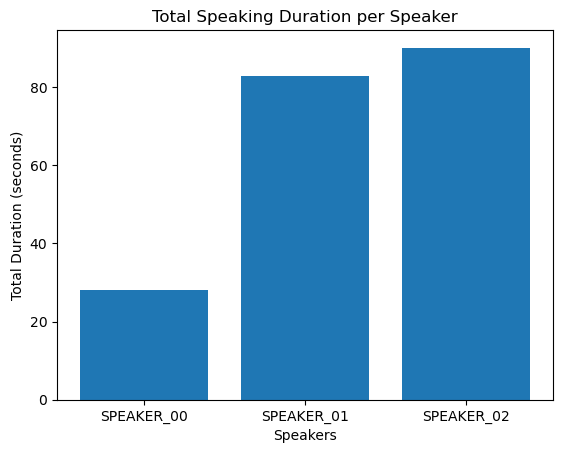

In [58]:
#Plot them on bar chart to visualise the difference.

total_durations = {
  "SPEAKER_00": speaker_0_df["Duration"].sum(),  
  "SPEAKER_01": speaker_1_df["Duration"].sum(),
  "SPEAKER_02": speaker_2_df["Duration"].sum(),
} 

labels = list(total_durations.keys())
values = list(total_durations.values())

#create plot
plt.bar(labels, values)

plt.xlabel("Speakers")
plt.ylabel("Total Duration (seconds)")
plt.title("Total Speaking Duration per Speaker")

#Show plot
plt.show()

### Transcription

As stated above Pyannote is useful for speaker diarisation but does not allow for transcribing the audio file, while whisper, transcribes but does not do speaker diarization. So we need to use a combination of the two. 

In order to transcribe the audio while retaining the speaker segmentation we need to split the audio file into individual segements. We can do this with the library [pydub](https://audiosegment.readthedocs.io/en/latest/audiosegment.html). 

In [59]:
#load audio file
audio = AudioSegment.from_mp3(file_path)

#output folder
segment_folder = "data\processed\Segments"

#Loop through segments
speaker_segments = []
for turn, _, speaker in diarisation.itertracks(yield_label=True):
    #change start and end times to milliseconds
    segment = audio[turn.start *1000:turn.end *1000]

    #pass the output folder
    segment_file = os.path.join(segment_folder, f"{speaker}_{int(turn.start)}_{int(turn.end)}.mp3")    
    segment.export(segment_file, format="mp3")

    speaker_segments.append({"speaker": speaker, "start": turn.start, "end": turn.end, "file": segment_file})



The above code has split the audio into segments based on the speaker changing. The output files are in order of speaker so when we transcribe it below, they will need to be resorted in order of start time.

In [60]:
# Transcribe Segments

segment_transcriptions = []

#for loop to transcribe each segment
for segment in os.listdir(segment_folder):
  if segment.endswith(".mp3"):
        # Full path to the audio file
        segment_path = os.path.join(segment_folder, segment)
        
        # Transcribe the audio segment
        print(f"Transcribing: {segment_path}")
        segment_result = model.transcribe(segment_path)

        # Extract speaker, start, and end info from the filename
        file_parts = os.path.splitext(segment)[0].split("_")
        speaker = f"SPEAKER{file_parts[1]}"
        start = float(file_parts[2])
        end = float(file_parts[3])

        # Append the transcription result
        segment_transcriptions.append({
            "speaker": speaker,
            "start": start,
            "end": end,
            "text": segment_result["text"]
        })

#sort by start time to retain order of conversation
segment_transcriptions = sorted(segment_transcriptions, key=lambda x: x['start'])

# Print the results
for transcription in segment_transcriptions:
  print(f"{transcription['speaker']} ({transcription['start']}-{transcription['end']}")



Transcribing: data\processed\Segments\SPEAKER_00_106_111.mp3


c:\Users\kolea\anaconda3\Lib\site-packages\whisper\transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribing: data\processed\Segments\SPEAKER_00_115_128.mp3
Transcribing: data\processed\Segments\SPEAKER_00_1_2.mp3
Transcribing: data\processed\Segments\SPEAKER_00_6_10.mp3
Transcribing: data\processed\Segments\SPEAKER_00_97_102.mp3
Transcribing: data\processed\Segments\SPEAKER_01_100_100.mp3
Transcribing: data\processed\Segments\SPEAKER_01_108_115.mp3
Transcribing: data\processed\Segments\SPEAKER_01_10_20.mp3
Transcribing: data\processed\Segments\SPEAKER_01_159_174.mp3
Transcribing: data\processed\Segments\SPEAKER_01_190_203.mp3
Transcribing: data\processed\Segments\SPEAKER_01_30_52.mp3
Transcribing: data\processed\Segments\SPEAKER_01_82_97.mp3
Transcribing: data\processed\Segments\SPEAKER_02_100_101.mp3
Transcribing: data\processed\Segments\SPEAKER_02_103_105.mp3
Transcribing: data\processed\Segments\SPEAKER_02_128_159.mp3
Transcribing: data\processed\Segments\SPEAKER_02_174_187.mp3
Transcribing: data\processed\Segments\SPEAKER_02_189_190.mp3
Transcribing: data\processed\Segments\

In [61]:
#Create transcribed file
full_transcription_file = "data/processed/full_transcription.txt"

In [62]:
#Combine transcribed files
full_transcription_file = "data/processed/full_transcription.txt"
with open(full_transcription_file, "w") as file:
  for t in segment_transcriptions:
    file.write(f"Speaker {t['speaker']} ({t['start']:.1f}s - {t['end']:.1f}s): {t['text']}\n")

print("Created full transcription text file!")

Created full transcription text file!


The above cells have taken a 3 mins 43 second long audio file and broken it down to 20 individual audio segments retaining the time they start and finish speaking. They have then been transcribed individually and pasted back together to from one text file.

### Large Language Models

There are a number of LLMs out there (the best known being ChatGPT),that are trained on vast amounts of data to understand and generate human-like language. It can generate new text based on context allowing it to answer questions and create its own content. 

If we pass the transcription that we have been able to produce to an LLM we can ask it questions about it. 

In [5]:
#hugging face have a transformer with a sentiment analysis

from transformers import pipeline
sentiment_analyzer = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [10]:
#open transcript as read only form
with open(full_transcription_file, "r") as file:
  transcript= file.read()

The max tokens to be uploaded to teh sentiment analyzer is 512 so we need to split the transcript into chunks.

In [ ]:
# Split the transcript by lines (each line corresponds to a speaker's contribution)
lines = transcript.split("\n")

# Analyze each speaker's sentiment
for line in lines:
    # Skip empty lines
    if line.strip():
        print(f"Line: {line}")
        result = sentiment_analyzer(line)
        print(f"Sentiment: {result}")

The [Hugging Face transformer](https://huggingface.co/blog/sentiment-analysis-python) library uses a pretrained model to tag data according to its sentiment, which can be either Positive, Negative or Neutral. 

It splits into smaller components called tokens. The tokens are then processed through a stack of transformer layers, which capture relationships between words and their contextual meaning. The output from the transformer then is fed into a classification head that maps it to a number of output classes (Positive, Negative or Neutral). The model also provides a confidence score for the predicted class. 

However based on quick eye ball test, we might be able to find a better model. For example it classifies the following line as Positive;

"In Springfield, they're eating the dogs, the people that came in, they're eating the cats, they're eating the pets of the people that live there. And this is what's happening in our country."

Lets look at OpenAi's ChatGPT instead

In [43]:
# Load a QA pipeline with a Hugging Face model
qa_pipeline = pipeline("question-answering", model="google/flan-t5-large")


Some weights of T5ForQuestionAnswering were not initialized from the model checkpoint at google/flan-t5-large and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [65]:
question = "how many speakers are there?"

response = qa_pipeline(context=transcript, question=question)
print(response['answer'])

Speaker 1: Hello. Speaker 2:


In [42]:
import openai
from Authtoken import chatgpt_token

# Set your API key
openai.api_key = chatgpt_token
url = "https://api.openai.com/v1/chat/completions"

headers = {
    "Authorization": f"Bearer {chatgpt_token}",
    "Content-Type": "application/json"
}

data = {
    "model": "gpt-4o-mini",
    "messages": [
        {"role": "system", "content": "You are a helpful assistant analyzing transcripts."},
        {"role": "user", "content": "Here is the transcription:\n\nSpeaker 1: Hello. Speaker 2: Hi there."},
        {"role": "user", "content": "Can you summarize this transcript?"}
    ]
}

response = requests.post(url, headers=headers, json=data)

if response.status_code == 200:
    print("Response:", response.json()['choices'][0]['message']['content'])
else:
    print("Error:", response.status_code, response.text)

Error: 429 {
    "error": {
        "message": "You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.",
        "type": "insufficient_quota",
        "param": null,
        "code": "insufficient_quota"
    }
}



In [30]:
def query_chatgpt(context, query):
  response = openai.ChatCompletion.create(
    model="gpt-4",
    messages= [
      {"role": "system", "content": "You will analyze transcripts of audiofiles and answer questions about them"},
      {"role": "user", "content": f"Here is the transcription:\n\n{context}"},
      {"role": "user", "content": query},
      ]
  )
  return responses['choices'][0]['message']['content']

user_query = "can you read this document?"




In [31]:
query_chatgpt(transcript, user_query)

APIRemovedInV1: 

You tried to access openai.ChatCompletion, but this is no longer supported in openai>=1.0.0 - see the README at https://github.com/openai/openai-python for the API.

You can run `openai migrate` to automatically upgrade your codebase to use the 1.0.0 interface. 

Alternatively, you can pin your installation to the old version, e.g. `pip install openai==0.28`

A detailed migration guide is available here: https://github.com/openai/openai-python/discussions/742


How